# Policy Based and Actor-Critic Methods

Until now, almost all the methods considered are **value-based methods**, they learn the values of actions and then select actions based on the estimated values. Their policies would not even exist without the value function estimates. However, we can consider a different approach. **Policy-based methods** learn directly a parameterized policy ([Sutton et al., **"Policy Gradient Methods for Reinforcement Learning with Function Approximation"**, NIPS, 2000](./papers/1999%20-%20Policy%20Gradient%20Methods%20for%20Reinforcement%20Learning%20with%20Function%20Approximation.pdf)) to select actions **without consulting a value function**:

$\displaystyle \pi_\theta(a|s,\theta)$

In that case, the objective is to maximize the performance of the parameterized policy based on the gradient of some **performance measure J** with respect to the policy parameter:

$\displaystyle \theta_{t+1} = \theta_t + \alpha \nabla J(\theta_t)$

The policy can be parameterized in any way, as long as it is **differentiable with respect to its parameters**. In practice, **to ensure exploration**, we generally require that the policy never becomes deterministic. As an example, we can parameterize the policy as a softmax distribution over the action preferences:

$\displaystyle \pi_\theta(a|s, \theta) = \frac{e^{h(s,a,\theta)}}{\sum_{b} e^{h(s,b, \theta)}}$

where **h is the preference function** for actions in states, which can be parameterized arbitrarily. For example, h might be computed by a neural network, where the parameter is the vector of all the connection weights of the network, or it could simply be a linear function.

It is rather natural to define the performance measure as the **expected discounted return from the initial state**: 

$\displaystyle J(\theta) = E_{s_0 \sim p_0 } [G_{\pi_{\theta}}] $

where $p_0$ is the distribution of the initial state and $G_{\pi_{\theta}}$ is the discounted return from the initial state under policy $\pi_{\theta}$.

We can now learn **stochastic policies** directly, with better performance under **partially observable environments**. The intuition is that because we can learn arbitrary probabilities of actions, the agent is less dependent on the Markov assumption. For example, if the agent can’t distinguish a handful of states from their emitted observations, the best strategy is often to act randomly with specific probabilities:

<img src="./images/stochastic-policies.png" width="900">

Interestingly, with stochastic policies, **exploration can be embedded in the learned function**.

Moreover, learning stochastic policies could be **more straightforward for function approximation**. Sometimes value functions are **too much informative** for what’s truly needed. It could be that calculating the exact value of a state or state-action pair is complicated or unnecessary:

<img src="./images/too-much-informative.png" width="800">

Finally, value-based methods are **prone to oscillations and even divergence**: tiny changes in value-function space may imply significant changes in action space. A significant difference in actions can create entirely unusual new trajectories, and therefore create instabilities. In policy-based methods, we instead follow the gradient with respect to stochastic policies, which only progressively and smoothly changes the actions. Therefore, policy-based methods often have **better convergence properties**.

A more powerful approach **combines the learning of both policies and value functions**. These methods are referred to as **actor-critic algorithms** because the policy (which selects actions) can be seen as an actor, and the value function (which evaluates policies) can be seen as a critic. Actor-critic methods often perform better than value-based or policy-gradient methods alone on many of the deep reinforcement
learning benchmarks.

## Policy Gradient Theorem

In order to learn the policy directly, we need to find the gradient of performance metric with respect to the policy parameters:

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta E_{s_0 \sim p_0 } [G_{\pi_{\theta}}] $

To simplify notation, let’s use a variable $\tau$ to represent a trajectory:

$\displaystyle \tau = S_0, A_0, R_1, S_1,..., S_{T-1}, A_{T-1}, R_T, S_T $

we can abuse notation and use $G$ function to obtain the return of the trajectory:

$\displaystyle G(\tau) = R_1 + \gamma R_2 + ... + \gamma^{T-1}R_T $

We can also express the **probability of a trajectory** as the probability of the initial states, then the action decided by the policy, then the probability of a transition, and so on until we have the product of all the probabilities that make the trajectory likely:

$\displaystyle p(\tau|\pi_\theta) = 
p_0(S_0) \pi_\theta(A_0|S_0) P(S_1|S_0,A_0) \pi_\theta(A_1|S_1)P(S_2|S_1,A_1)...P(S_T|S_{T-1},A_{T-1}) = 
p_0\prod\limits_{t=0}^{T-1}{P(s_{t+1}|s_t,a_t)\pi_\theta(a_t|s_t)} $

Of course, we don't know the distribution of the start state or the probability of the transitions, because we don't have the model of the environment. 

Using this notation, we can rewrite the objective as:

$\displaystyle J(\theta) = E_{\tau \sim \pi_\theta } \left[ G(\tau) \right] = \sum\limits_{\tau} p(\tau|\pi_\theta) G(\tau)$

The problem is that we can't just evaluate the gradient of this score function because we don't have complete knowledge of the problem, it is a mix of factors that are under our control via the parameters (policy) and factors that are not known (environment model).

In order to provide an estimation of the gradient of the objective function (without knowing the transition function), we have to make some mathematical manipulations in order to remove the unknown factors from the equation. We can rewrite the gradient of the sum as the sum of the gradient:

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta \sum\limits_{\tau}{p(\tau|\pi_\theta)G(\tau)} = \sum\limits_{\tau}{\nabla_\theta p(\tau|\pi_\theta)G(\tau)} = $

we then multiply every term in the sum by and rewrite in order to obtain the likelihood ratio:

$\displaystyle = \sum\limits_{\tau}{\frac{p(\tau|\pi_\theta)}{p(\tau|\pi_\theta)} \nabla_\theta p(\tau|\pi_\theta)G(\tau)} = \sum\limits_{\tau}{p(\tau|\pi_\theta) \frac{ \nabla_\theta p(\tau|\pi_\theta)}{p(\tau|\pi_\theta)} G(\tau)} = $

now we we can use a mathematical result called **likelihood ratio**, which states that the gradient of the function divided by the function itself
is equal to the gradient of the log of a function:

$\displaystyle = \sum\limits_{\tau}{p(\tau|\pi_\theta) \nabla_\theta \log p(\tau|\pi_\theta) G(\tau)} $

Thanks for this formula, we can estimate the gradient using $m$ trajectory samples:

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{\nabla_\theta \log p(\tau^{(i)}|\pi_\theta)G(\tau^{(i)})} $

where $\tau^{(i)}$ is a trajectory sampled.

We still have some mathematics work in order to simplify the formula, we can substitute the definition of the transition probability:

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{ \nabla_\theta \log \left[ p_0\prod\limits_{t=0}^{T-1}{P(s_{t+1}^{(i)}|s_t^{(i)},a_t^{(i)})\pi_\theta(a_t^{(i)}|s_t^{(i)})} \right] G(\tau^{(i)})} = $

and we know that the log of a product is equal to the sum of the logs:

$\displaystyle = \frac{1}{m}\sum\limits_{i=1}^{m}{ \nabla_\theta \left[ \log p_0 + \sum\limits_{t=0}^{T-1}{\log P(s_{t+1}^{(i)}|s_t^{(i)}, a_t^{(i)})}  + \sum\limits_{t=0}^{T-1}{\log \pi_\theta(a_t^{(i)}|s_t^{(i)})}   \right] G(\tau^{(i)})} $

we also know that the gradient of the sum is equal to the sum of gradient:

$\displaystyle = \frac{1}{m}\sum\limits_{i=1}^{m}{ \left [\nabla_\theta \log p_0 + \nabla_\theta \sum\limits_{t=0}^{T-1}{\log P(s_{t+1}^{(i)}|s_t^{(i)}, a_t^{(i)})}  + \nabla_\theta \sum\limits_{t=0}^{\log \pi_\theta(a_t^{(i)}|s_t^{(i)})} \right ] G(\tau^{(i)})} = $

since neither initial state distribution or state transition dynamics are dependent of $\theta$, the derivate of both terms can be removed:

$\displaystyle = \frac{1}{m}\sum\limits_{i=1}^{m}{ \nabla_\theta \sum\limits_{t=0}^{T-1}{\log \pi_\theta(a_t^{(i)}|s_t^{(i)})} G(\tau^{(i)})}$

finally, we can rewrite the gradient of the sum as the sum of gradients and the formula for estimating the gradient of the objective function is: 

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{ \sum\limits_{t=0}^{T-1}{\nabla_\theta \log \pi_\theta(a_t^{(i)}|s_t^{(i)})} G(\tau^{(i)})} $

We have a way to compute the policy gradient without knowing anything about the environment’s transition function: we first collect a full trajectory $\tau$ and calculate the full discounted return $G(\tau)$ and then we use that to weight the log probabilities of every action taken in that trajectory: $A_t, A_{t+1},..., A_{T–1}$. 

However, it is better to use only the **causal reward** that come after each action, because we know we can’t go back in time and current actions cannot be responsible for past reward. 

<img src="./images/causal.png" width="550">

For each step in the trajectory, we calculate the return just from that step and use that value as the score to weight the log probability of the action taken at that time step:

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{ \sum\limits_{t=0}^{T-1}{\nabla_\theta \log \pi_\theta(a_t^{(i)}|s_t^{(i)})} G_t(\tau^{(i)})} $


## REINFORCE 

The REINFORCE algorith ([R.J. Williams, **"Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning"**, Machine Learning (1992)](./papers/1992%20-%20Simple%20Statistical%20Gradient-Following%20Algorithms%20for%20Connectionist%20Reinforcement%20Learning.pdf)) was one of the first attempts to implements the idea, estimating the gradient using the full Monte Carlo returns and using a neural network to represent the policy. First of all we implement the parametric policy as a neural network, that takes the state as input and outputs a probability distribution over the actions:

In [9]:
import torch

class PolicyApproximator(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyApproximator, self).__init__()

        # activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # hidden layer
        self.hidden_layer = torch.nn.Linear(512, 128)
        
        # output layer    
        self.output_layer = torch.nn.Linear(128, action_size)
        
    def forward(self, state):
        
        # convert the state into a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for the hidden layer
        x = self.activation(self.hidden_layer(x))

        # finally, pass for the output layer
        preferences = self.output_layer(x)

        return preferences
    
    def select_action(self, state):

        # get the preferences over actions
        preferences = self.forward(state)

        # sample the action from the probability distribution
        dist = torch.distributions.Categorical(logits=preferences)
        action = dist.sample()

        # calculate the log probability of the action 
        # needed for the loss
        logpa = dist.log_prob(action).unsqueeze(-1)

        return action.item(), logpa
    
    def select_greedy_action(self, state):
        
        # select the action with the highest preference
        preferences = self.forward(state)
        action = np.argmax(preferences.detach())
        
        return action.item()
    

We write the optimization method in order to calculate the performance value. Notice that, in order to have a loss function (to be used in the gradient descent algorithm), we can use the negative of the performance measure as the objective function. Then we use the optimizer to make a step of gradient descent.  

In [10]:
def optimize(model, rewards, logpas, discounts, optimizer):
    
    # get the length of the episode
    T = len(rewards)
    
    # calculate the sum of discounted returns for all steps
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # format the variables as a tensor
    returns = torch.FloatTensor(returns)
    
    # prepare the log probabilities of the actions taken in the episode
    logpas = torch.cat(logpas)

    # calculate the policy loss
    loss = -(returns * logpas).sum()
    
    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

This time we don't need to create methods to implement epsilon-greedy and greedy strategies, because we can use directly the output of the neural network as a probability distribution over the actions. In the evaluate method, instead of selecting only in a greedy way, **we can sample from the learned stochastic policy**. The correct thing to do depends on the environment, but sampling is the safe bet.

In [11]:
def evaluate(approximator, env, episodes=1):
    rewards = []
    for _ in range(episodes):
        state = env.reset()[0]
        rewards.append(0)
        while(True):
            action = approximator.select_greedy_action(state)
            state, reward, is_terminal, is_truncated, info = env.step(action)
            rewards[-1] += reward
            is_done = is_terminal or is_truncated
            if is_done: 
                break
    return np.mean(rewards)

Finally, we can write the complete algorithm, where we collect a full trajectory and then perform an optimization step:

In [12]:
import time
import numpy as np
import random
from itertools import count
import gymnasium
import gc

def reinforce(env_name, seed, parameters):

    # unpack the parameters
    gamma = parameters['gamma']
    learning_rate = parameters['learning_rate']
    max_time = parameters['max_time']
    max_episodes = parameters['max_episodes']
    max_score = parameters['max_score']
    episodes_window = parameters['episodes_window']
 
    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # calculate the discounts to be used in the episodes
    max_steps = 1000
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma)

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the policy model
    policy_model = PolicyApproximator(state_size, action_size)
    
    # create the optimizer
    optimizer = torch.optim.RMSprop(policy_model.parameters(), 
                                    lr=learning_rate)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = []  

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
    
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # log the rewards and the log of action probabilities
        logpas = []
        rewards = []

        # interact with the environment until the episode is done
        for step in count():
            
            # select the action using the policy
            action, logpa = policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # save the log probability and the reward
            logpas.append(logpa)
            rewards.append(reward)

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done: 
                gc.collect()
                break
        
        # then, run one optimization step
        optimize(policy_model, rewards, logpas, discounts, optimizer)

        # evaluate the learned policy after the episode
        score = evaluate(policy_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  

        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
    
    return policy_model, score, results

We can run REINFORCE in the cart-pole environment so that we can easily compare it and the DQN value-based method.

In [13]:
def run_experiment( name = 'reinforce',
                    env_name = 'CartPole-v1',
                    algorithm = reinforce, 
                    seeds = (12, 34, 56, 78, 90),
                    parameters = None):
    
    # variables to collect results
    results = []
    best_agent = None
    best_eval_score = float('-inf')
    
    for seed in seeds:
        # create the agent
        agent, score, result = algorithm(env_name, seed, parameters)

        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent
    
    np.save("".join(['../models/', name]), results)

    return results, best_agent, best_eval_score

In [14]:
parameters = {
  'gamma': 0.99, 
  'learning_rate': 0.0007,
  'max_episodes': 3000,
  'max_time': 4*60, 
  'max_score': 450, 
  'episodes_window': 50
}

reinforce_results, reinforce_agent, reinforce_score = run_experiment(name = 'reinforce_results', algorithm = reinforce, parameters = parameters) 

episode 0641, steps 100552, average score 451.5  --> reached_max_score 
episode 0995, steps 120646, average score 133.3  --> reached_max_time 
episode 0173, steps 001448, average score 009.5  --> reached_max_time 
episode 0338, steps 045626, average score 413.7  --> reached_max_time 
episode 0704, steps 005949, average score 009.2  --> reached_max_time 


We can load the results of DQN in order to compare the performances of the two algorithms:

In [15]:
dqn_results = np.load('../models/dqn_results.npy')

As for value-based algorithms, we can plot the performance of the algorithm over episodes:   

In [16]:
import matplotlib.pyplot as plt

def show_result(what, alg_a_name, alg_a_results, alg_b_name, alg_b_results):

    plt.figure(figsize=(12,6))
    
    # steps, train_reward,  eval_score,  time
    alg_a_max  = np.max(alg_a_results, axis=0).T
    alg_a_min  = np.min(alg_a_results, axis=0).T
    alg_a_mean = np.mean(alg_a_results, axis=0).T
    alg_a_episodes = np.arange(len(alg_a_mean[0]))

    alg_b_max  = np.max(alg_b_results, axis=0).T
    alg_b_min  = np.min(alg_b_results, axis=0).T
    alg_b_mean = np.mean(alg_b_results, axis=0).T
    alg_b_episodes = np.arange(len(alg_b_mean[0]))

    if (what == 'total_steps'):
        index = 0;
        title = 'Total Steps'
        label = 'Steps'
    elif(what == 'avg_training_reward'):
        index = 1;
        title = 'Moving Avg Reward (Training)'
        label = 'Reward'
    elif(what == 'avg_evaluation_reward'):
        index = 2;
        title = 'Moving Avg Reward (Evaluation)'
        label = 'Reward'
    elif(what == 'training_time'):
        index = 3;
        title = 'Trainning time)'
        label = 'Time'
    else:
        raise ValueError('Not sure what you want to plot')

    plt.plot(alg_a_max[index], 'b', linewidth=1, label=alg_a_name)
    plt.plot(alg_a_min[index], 'b', linewidth=1)
    plt.plot(alg_a_mean[index], 'b', linewidth=1)
    plt.fill_between(alg_a_episodes, alg_a_min[index], alg_a_max[index], facecolor='b', alpha=0.3)

    plt.plot(alg_b_max[index], 'g', linewidth=1, label=alg_b_name)
    plt.plot(alg_b_min[index], 'g', linewidth=1)
    plt.plot(alg_b_mean[index], 'g', linewidth=1)
    plt.fill_between(alg_b_episodes, alg_b_min[index], alg_b_max[index], facecolor='g', alpha=0.3)

    plt.title(title)
    plt.ylabel(label)
    plt.xlabel('Episodes')
    plt.legend()

    plt.show()

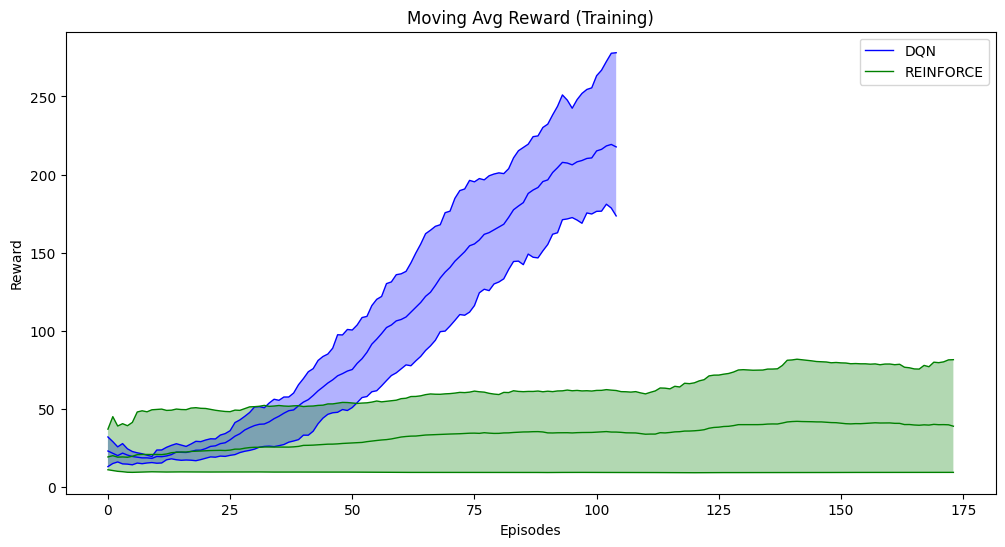

In [17]:
show_result('avg_training_reward','DQN', dqn_results, 'REINFORCE', reinforce_results) 

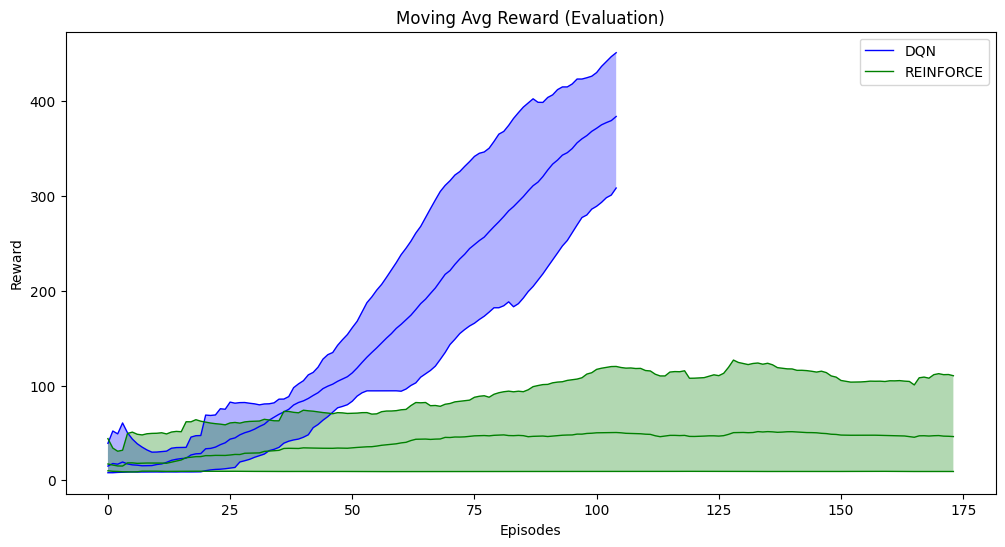

In [18]:
show_result('avg_evaluation_reward','DQN', dqn_results, 'REINFORCE', reinforce_results) 

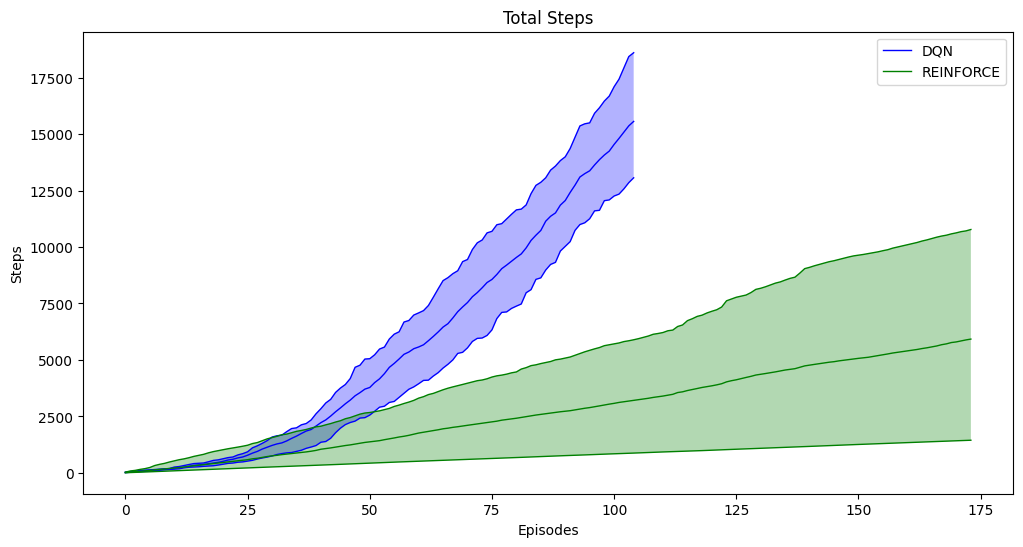

In [19]:
show_result('total_steps','DQN', dqn_results, 'REINFORCE', reinforce_results) 

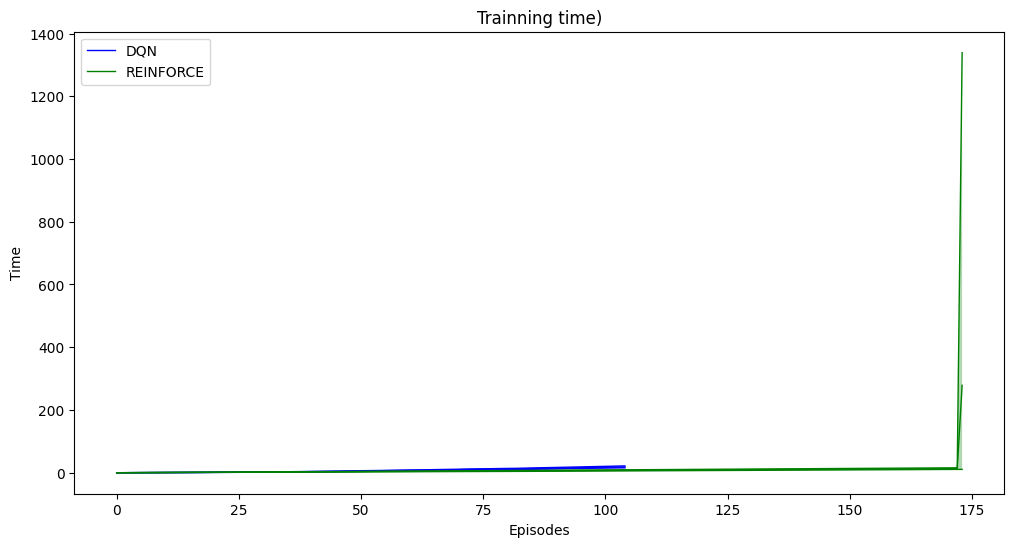

In [20]:
show_result('training_time','DQN', dqn_results, 'REINFORCE', reinforce_results) 

The REINFORCE algorithm **works well in simple problems**, and it has **convergence guarantees**. However, because it uses the full Monte Carlo returns for calculating the gradient, **its variance is a problem**. The accumulation of random events along a trajectory (including the initial state) and the randomness associated with the stochastic policy is compounded inside the return, making it a high-variance signal that's challenging to interpret. So, REINFORCE alone is **too inefficient** to be a practical algorithm. However, in terms of training time, we can see how it uses few resources.

## Vanilla Policy Gradient (VPG)

The key idea underlying policy gradient is to push up the probabilities of actions that lead to higher return, and push down the probabilities of actions that lead to lower return, until we arrive at the optimal policy. However, using a (noisy) Monte Carlo estimate of the return introduces high variance in the policy gradient estimate, which can make learning slow. Imagine an environment (such as the cart-pole) in which all rewards are positive, in order to accurately separate good actions from the best actions, we need a lot of data. 

It would be handy if we could use something that allows us to **differentiate the values of actions in the same state**, to do this we can exploit the **action-advantage function**:

$\displaystyle a_\pi(s,a) = q_\pi(s,a) - v_\pi(s) $

we can say that the advantage function is approximately the following:

$\displaystyle A(S_t,A_t) = R_t + \gamma R_{t+1} + ... + \gamma^{T-1} R_T - v_\pi(S_t) $

An estimate of it is the return minus the estimated expected return from that state:

$\displaystyle A(S_t,A_t) = G_t - V(S_t) $

Using the advantage somewhat **centers scores around zero**: better-than-average actions have a positive score (increasing probabilities), worse-than-average have a negative score (decreasing probabilities). However, we need two neural networks, one for learning the policy as before and one for learning the state-value function in order to estimate the advantage: 

<img src="./images/networks.png" width="800">

The loss for the value function is simple, the mean squared Monte Carlo error:

$\displaystyle L_v(\phi)=\frac{1}{m}\sum\limits_{i=0}^{m}{\left[\left(G_t(\tau^{(i)}) - V(s_t^{(i)};\phi)\right)^2\right]} $

For the policy network, we can update the gradient of the performance measure using the estimated advantage :

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{ \sum\limits_{t=0}^{T-1}{\nabla_\theta \log \pi_\theta(a_t^{(i)}|s_t^{(i)})} (G_t(\tau^{(i)})} - V(s_t^{(i)};\phi)) $

However, another essential improvement is to add an **entropy term** to to the loss function. We can interpret entropy in many different ways, from the amount of information we can gain by sampling from a distribution, to the number of ways we can order a set. In this context, we can think of entropy in a straightforward way. A uniform distribution, which has evenly distributed samples, has high entropy. If we have two samples, both with a 50% chance, then the entropy is the highest it can be for a two-sample set, conversely, if we have two samples, one with 100% chance, then the entropy is the lowest. The way to use entropy in policy-gradient methods is to add the weighted entropy to the performance function **to encourage having evenly distributed actions**. That way, a policy (with evenly distributed actions) yields the highest entropy and contributes to maximize the performance. On the other hand, converging on a single action (which means entropy is zero) doesn’t increase the performance measure.

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{ \sum\limits_{t=0}^{T-1}{\nabla_\theta [ \log \pi_\theta(a_t^{(i)}|s_t^{(i)})} (G_t(\tau^{(i)})} - V(s_t^{(i)};\phi)) + \beta H(s_t^{(i)};\theta) ]$

This algorithm is called **Vanilla policy gradient**. We may be wondering, is this a first example of actor-critic? It’s learning a policy and a value-function, so it seems it should be. However, according to the definition accepted in the field, only methods that learn the value function using bootstrapping should be called actor-critic, because it’s bootstrapping that adds bias to the value function, and thus makes it a "critic". Therefore, REINFORCE and VPG aren’t considered actor-critic methods. But beware of the lingo, it’s not consistent.

We need a new neural network to approximate the state-value function:

In [21]:
class ValueApproximator(torch.nn.Module):
    def __init__(self, state_size):
        super(ValueApproximator, self).__init__()

        # define the activation function (ReLU)
        self.activation = torch.nn.functional.relu

        # defining the input layer
        self.input_layer = torch.nn.Linear(state_size, 512)

        # creating the hidden layers 
        self.hidden_layers = torch.nn.ModuleList()
        self.hidden_layers.append(torch.nn.Linear(512, 128))
        
        # connecting the output layer    
        self.output_layer = torch.nn.Linear(128, 1)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        if not isinstance(state, torch.Tensor):
            state = torch.Tensor(state)

        # pass it through the input layer
        x = self.activation(self.input_layer(state))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # finally, pass for the output layer
        value = self.output_layer(x)

        return value

We need also to the select_action method of the first network (the policy network) in order to calculate also the entropy term:

In [22]:
def select_action(self, state):

    # get the preferences over actions
    preferences = self.forward(state)

    # sample the action from the probability distribution
    dist = torch.distributions.Categorical(logits=preferences)
    action = dist.sample()

    # calculate the log probability of the actions, it is needed for the loss
    logpa = dist.log_prob(action).unsqueeze(-1)

    # calculate the entropy
    entropy = dist.entropy().unsqueeze(-1)

    return action.item(), logpa, entropy

PolicyApproximator.select_action = select_action

The optimize method is different from the previous one, because we have two neural networks to optimize:  

In [23]:
def optimize(policy_model, value_model, 
             rewards, logpas, values, entropies, 
             policy_optimizer, value_optimizer, 
             discounts):
    
    # get the length of the episode
    T = len(rewards)
    
    # calculate the sum of discounted returns for all steps
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # format the variables as a tensor
    returns = torch.FloatTensor(returns)
    
    # prepare the log probabilities, the entropies and the values
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies) 
    values = torch.cat(values)
    
    # estimate the advantages
    advantage = returns - values

    # calculate the policy loss
    beta = 0.001
    policy_loss = -(advantage.detach() * logpas + beta * entropies).sum()

    # calculate the value loss
    value_loss = advantage.pow(2).sum()
        
    # optimize the policy network
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    # optimize the value network
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

Finally, we can write the complete algorithm, similar to REINFORCE, but with the addition of the value network and the entropy term:

In [24]:
def vpg(env_name, seed, parameters):

    # unpack the parameters
    gamma = parameters['gamma']
    learning_rate = parameters['learning_rate']
    max_time = parameters['max_time']
    max_episodes = parameters['max_episodes']
    max_score = parameters['max_score']
    episodes_window = parameters['episodes_window']

    # create the environment
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # calculate the discounts to be used in the episodes
    max_steps = 1000
    discounts = np.logspace(start=0, stop=max_steps , num=max_steps, base=gamma)

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.np_random = np.random.Generator(np.random.PCG64(seed))

    # create the policy model and its optimizer
    policy_model = PolicyApproximator(state_size, action_size)
    policy_optimizer = torch.optim.RMSprop(policy_model.parameters(), lr=learning_rate)

    # create the value model and its optimizer
    value_model = ValueApproximator(state_size)
    value_optimizer = torch.optim.RMSprop(value_model.parameters(), lr=learning_rate)

    # episode stats trackers 
    episode_steps = []
    episode_return = []
    episode_seconds = []
    episode_scores = [] 

    # total stats trackers
    total_step = 0
    training_time = 0
    results = np.empty((max_episodes+1, 4))
    results[:] = np.nan
        
    # train until we reach a terminal condition
    for episode in count():

        # get the start time of the episode
        episode_start = time.time()
        
        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # log the rewards, the log of action probabilities, entropies and values
        logpas = []
        rewards = []
        entropies = []
        values = []
        
        # interact with the environment until the episode is done
        for step in count():
    
            # select the action using the policy
            action, logpa, entropy = policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # calculate the value using the value network
            value = value_model(state)

            # save the log probability, entropy, reward and value
            logpas.append(logpa)
            entropies.append(entropy)
            rewards.append(reward)
            values.append(value)

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
            
            if is_done:
                gc.collect() 
                break

        # then, run one optimization step
        optimize(policy_model, value_model, rewards, logpas, values, entropies, policy_optimizer, value_optimizer, discounts)

        # evaluate the learned policy after the episode
        score = evaluate(policy_model, env)

        # timing stuff
        episode_elapsed = time.time() - episode_start

        # update episode stats
        episode_steps.append(step)
        episode_return.append(discounted_return)
        episode_seconds.append(episode_elapsed)
        episode_scores.append(score)

        # update total stats
        total_step += step
        training_time += episode_elapsed  

        # average stats over some recent episodes
        mean_return = np.mean(episode_return[-episodes_window:])
        mean_score = np.mean(episode_scores[-episodes_window:])

        # report results
        results[episode] = total_step, mean_return, mean_score, training_time

        # informative print logging  
        message = 'episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(episode, total_step, mean_score)
        print(message, end='\r', flush=True)

        # check max episodes achievement criteria
        if (episode >= max_episodes):
            print(message, ' --> reached_max_episodes ')
            break

        # check max time achievement criteria
        if (training_time >= max_time):
            print(message, ' --> reached_max_time ')
            break

        # check max score achievement criteria
        if (mean_score >= max_score):
            print(message, ' --> reached_max_score ')
            break
    
    return policy_model, score, results

We can try the algorithm in the cartpole environment:

In [25]:
vpg_results, vpg_agent, vpg_score = run_experiment(name = 'vpg_results', algorithm = vpg) 

TypeError: 'NoneType' object is not subscriptable

We can compare VPG with REINFORCE, Notice how VPG is more sample efficient, instead REINFORCE is too inefficient to be a practical algorithm.

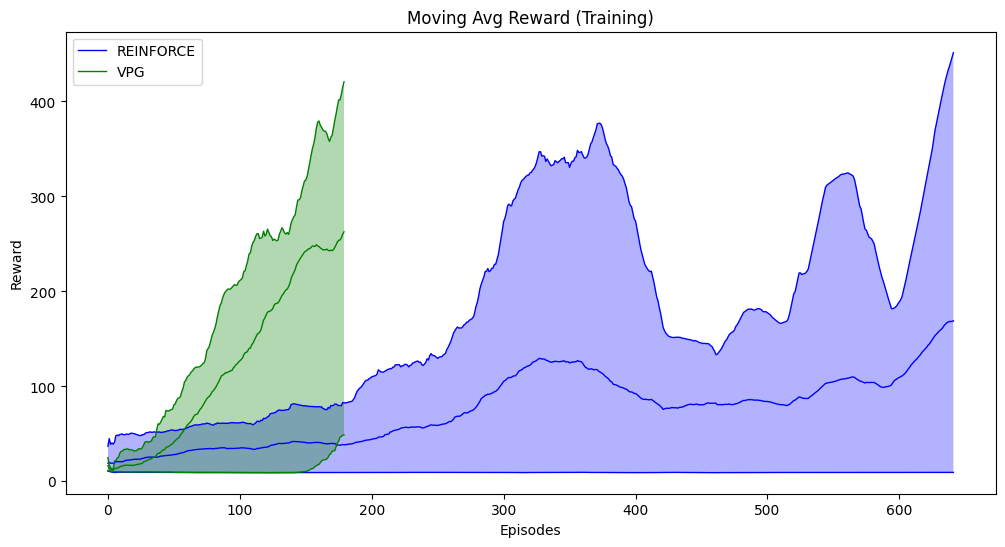

In [ ]:
show_result('avg_training_reward','REINFORCE', reinforce_results, 'VPG', vpg_results) 

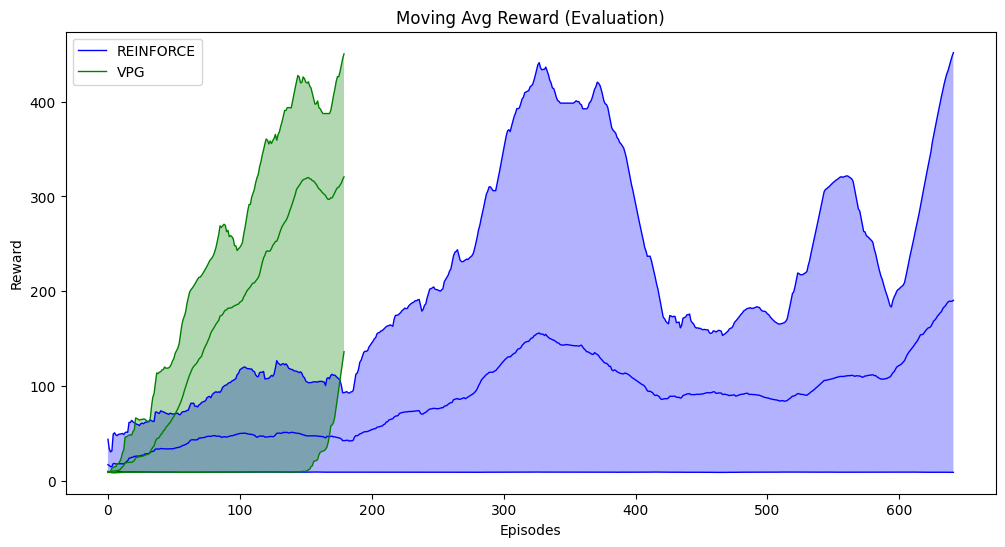

In [ ]:
show_result('avg_evaluation_reward','REINFORCE', reinforce_results, 'VPG', vpg_results) 

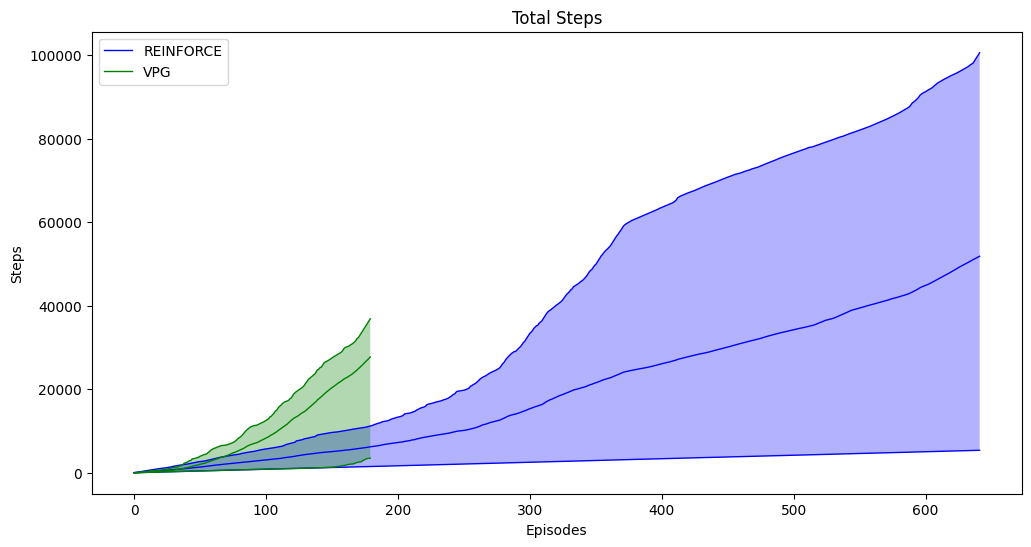

In [ ]:
show_result('total_steps','REINFORCE', reinforce_results, 'VPG', vpg_results) 

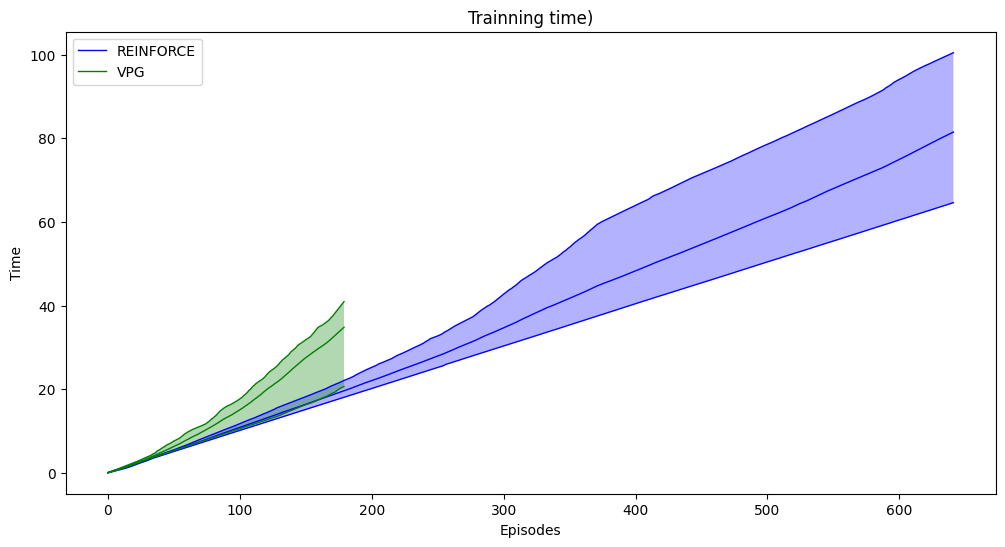

In [ ]:
show_result('training_time','REINFORCE', reinforce_results, 'VPG', vpg_results) 

VPG is a pretty robust method for simple problems; it is, for the most part, unbiased because it uses an unbiased target for learning both the policy and value function. That is, it uses Monte Carlo returns, which are complete actual returns experienced directly in the environment, without any bootstrapping. The only bias in the entire algorithm is because we use function approximation, which is inherently biased.

## Asynchronous Advantage Actor-Critic (A3C)

One of the main sources of variance in DRL algorithms is how **correlated and non-stationary** online samples are. In value-based methods, we use a replay buffer to uniformly sample mini-batches of (for the most part) independent and identically distributed data. Unfortunately, this is limited to off-policy methods, because on-policy agents cannot reuse data generated by previous policies. In on-policy methods (likes the policy-based methods), instead of using the replay buffer, we can have **multiple workers generating experience** on **multiple instances of the environment** in parallel and asynchronously updating the policy and value function. This can help to de-correlate the data used for training and to reduce the variance of the algorithm.

![](./images/multiple-workers.png)

The **Asynchronous Advantage Actor-Critic (A3C)** algorithm ([Vlad Mnih et al. **"Asynchronous Methods for Deep Reinforcement Learning"**, ICML 2016)](./papers/2016%20-%20Asynchronous%20Methods%20for%20Deep%20Reinforcement%20Learning.pdf) uses concurrent actors to generate a broad set of experience samples in parallel.  Moreover, it also uses **n-step returns with bootstrapping** to learn the policy and value function.




This behavior can be implemented using **multiple threads**, one for each worker, however Python threads cannot take advantage of CPU with multiple cores, due to  internal implementation details. The workaround is to use **multiple processes** using the multiprocessing module. Unfortunately, the multiprocessing library has problems in running in an iterative environment like Jupyter, so we will use the threading library. We need to create a work function that will be executed by each thread. In the following example, the work function just waits for a random time before printing its rank: 

In [ ]:
import time

def work(rank, sleep_time):
    time.sleep(sleep_time)
    print(rank) 

Then we create a pool of threads, execute them in parallel and finally wait for the threads to finish:

In [ ]:
import random

from threading import Thread

def main():
    # number of workers
    n_workers = 4

    print('start')
    if __name__ == '__main__':
        
        workers = [Thread(target=work, args=(rank, random.uniform(1, 3),)) for rank in range(n_workers)]  

        # start workers
        [w.start() for w in workers]

        # wait for all workers to finish
        [w.join() for w in workers]

    print('end')

main()

start
1
0
3
2
end


As you can see, workers are running in parallel: since they wait for a different amount of time, the order of the output is not deterministic. However, we can see that the rank of the thread is always the same, because the pool of threads is created with a fixed number of workers. Moreover, the "end" string is always printed at the end, because the main thread waits for the completion of all the workers.

Moreover, when writing concurrent programs we may need to share data or resources between threads. Since threads live in the same memory space, they have access to the same (public) data. Thus, we can for example simply use a global variable to which all threads have read and write access. Moreover,  typically we need be protect with a mutual exclusion lock some shared variables in order to prevent race conditions. Python provides a mutual exclusion lock for use with processes via the Lock class. In this example, we create a shared counter and we use a lock to synchronize access to it:

In [ ]:
def work(rank, iterations, lock):

    # all threads can access this shared variable
    global counter

    for _ in range(iterations):

        time.sleep(random.uniform(1, 10)/100)

        # lock the shared variable
        lock.acquire()

        counter += 1
        print(counter, " - int's me ", rank)

        # unlock the shared variable
        lock.release()

In [ ]:
from threading import Lock

# number of workers
n_workers = 4

print('start')

# number of iterations per worker
iterations = 5

# shared variable
counter = 0

# create a lock
lock = Lock()
    
# create workers
workers = [Thread(target=work, args=(rank, iterations, lock)) for rank in range(n_workers)]  

# start workers
[w.start() for w in workers]

# wait for all workers to finish
[w.join() for w in workers]

print ('end')

start


1  - int's me  1
2  - int's me  2
3  - int's me  0
4  - int's me  3
5  - int's me  2
6  - int's me  0
7  - int's me  3
8  - int's me  0
9  - int's me  1
10  - int's me  2
11  - int's me  3
12  - int's me  0
13  - int's me  2
14  - int's me  1
15  - int's me  0
16  - int's me  1
17  - int's me  3
18  - int's me  3
19  - int's me  2
20  - int's me  1
end


We can write the work function used by each agent in the A3C algorithm. The agent interacts with the environment ad update the global networks parameters:

In [ ]:
# create a global object to share information between the workers
shared_info = {}

In [ ]:
def agent_work(rank, lock):
    
    # access the global shared variables
    global shared_info

    # create a different seed for each worker, since we need different
    # experiences from each one of them
    local_seed = shared_info['seed'] + rank
    
    # create the local environment
    env = gymnasium.make(shared_info['env_name'])

    # create a uniquely seeded environment for each worker
    env.np_random = np.random.Generator(np.random.PCG64(local_seed))
    
    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    # create the local policy model 
    # initialize weights with the weights of the shared policy model
    local_policy_model = PolicyApproximator(state_size, action_size)
    local_policy_model.load_state_dict(shared_info['shared_policy_model'].state_dict())
    
    # do the same thing with the value model
    local_value_model = ValueApproximator(state_size)
    local_value_model.load_state_dict(shared_info['shared_value_model'].state_dict())

    # increment the global episodes counter
    with lock:
        shared_info['episode'] = shared_info['episode'] + 1
        local_episode = shared_info['episode']

    # start the training loop, until the worker is signaled to get out of it
    # we reach a terminal condition
    while not shared_info['out_signal']: 

        # get the start time of the episode
        episode_start = time.time()

        # set return to 0
        discounted_return = 0
        
        # reset the environment before starting the episode
        state = env.reset()[0]
        
        # log the rewards, the log of action probabilities, entropies and values
        logpas = []
        rewards = []
        entropies = []
        values = []

        n_steps_start = 0

        # interact with the environment
        for step in count():
            
            # select the action using the local policy
            action, logpa, entropy = local_policy_model.select_action(state)

            # collect an experience tuple as usual 
            next_state, reward, is_terminal, is_truncated, info = env.step(action)
            is_done = is_terminal or is_truncated
            is_failure = is_terminal and not is_truncated

            # calculate the value using the value network    
            value = local_value_model(state)

            # save the log probability, entropy, reward and value
            logpas.append(logpa)
            entropies.append(entropy)
            rewards.append(reward)
            values.append(value)

            # update current state to next state
            state = next_state
        
            # update the return
            discounted_return += reward
                                    
            # if we collected enough steps or if the episode is done
            # calculate the n-step return and optimize the model
            if is_done or step - n_steps_start == shared_info['max_n_steps']:
                
                # if it’s a failure, then the value of the next state is 0; otherwise, we bootstrap
                next_value = 0 if is_failure else value.detach().item()
                rewards.append(next_value)
                
                # optimize the model
                optimize(logpas, entropies, rewards, values, 
                         local_policy_model, local_value_model,
                         shared_info['shared_policy_model'], 
                         shared_info['shared_value_model'],
                         shared_info['shared_policy_optimizer'], 
                         shared_info['shared_value_optimizer'],
                         shared_info['discounts'])
                
                # load the shared updated models parameters into the local models
                local_policy_model.load_state_dict(shared_info['shared_policy_model'].state_dict())
                local_value_model.load_state_dict(shared_info['shared_value_model'].state_dict())
                
                logpas = []
                entropies = [] 
                rewards = []
                values = []

                n_steps_start = step

            if is_done:
                break

        # evaluate the local policy after the episode
        score = evaluate(local_policy_model, env)

        # update total stats
        episode_elapsed = time.time() - episode_start
        with lock:
            shared_info['total_steps'] += step
            shared_info['training_time'] += episode_elapsed / shared_info['n_workers']

        # update global episode stats
        with lock:
            shared_info['episode_steps'].append(step)
            shared_info['episode_return'].append(discounted_return)
            shared_info['episode_seconds'].append(episode_elapsed)
            shared_info['episode_scores'].append(score)  
        
        # average stats over some recent episodes
        episodes_window = shared_info['episodes_window']
        mean_return = np.mean(shared_info['episode_return'][-episodes_window:])
        mean_score = np.mean(shared_info['episode_scores'][-episodes_window:])

        # report results
        shared_info['results'][local_episode] = step, mean_return, mean_score, episode_elapsed / shared_info['n_workers']

        # informative print logging  
        message = 'worker {:02} - episode {:04}, steps {:06}, average score {:05.1f}'
        message = message.format(rank, local_episode, shared_info['total_steps'], mean_score)
        with lock:
            print(message, end='\r', flush=True)

        # check if we should stop
        if shared_info['out_signal'] == 1:
            break

        # check max episodes achievement criteria   
        if (local_episode >= shared_info['max_episodes']):
            print(message, ' --> reached_max_episodes ')
            shared_info['out_signal'] = 1
            break

        # check max time achievement criteria
        if (shared_info['training_time'] >= shared_info['max_time']):
            print(message, ' --> reached_max_time ')
            shared_info['out_signal'] = 1
            break

        # check max score achievement criteria
        if (mean_score >= shared_info['max_score']):
            print(message, ' --> reached_max_score ')
            shared_info['out_signal'] = 1
            break
            
        # else go work on another episode by
        # getting a new episode id from the
        # global protected counter
        with lock:
            shared_info['episode'] = shared_info['episode'] + 1
            local_episode = shared_info['episode']

    env.close() 
    del env

Workers append the value of the next state, whether terminal or not, to the reward sequence before calling the optimize function (in VPG we were using the full returns for the advantage estimate). In that way, the reward variable contains all rewards from the partial trajectory and the state-value estimate of that last state. We can see this as having the partial return (the sequence of rewards) and the **predicted remaining return** in the same place. You can realize that this is an **n-step return**: the agent go out for n-steps collecting rewards, and then **bootstrap** after that n-th state (or before if he lands on a terminal state that comes first):

$\displaystyle A(S_t,A_t) = R_t + \gamma R_{t+1} + ... \gamma^n R_{t+n} + \gamma^{n+1} V(S_{t+n+1}) - V(S_t) = G_{t:t+n} - V(S_{t+n+1}) $

Notice the bootstrapping, this is what makes this algorithm an **actor-critic method**. Now, We can use that n-step return to improve the value function estimate: 

$\displaystyle L_v(\phi)=\frac{1}{m}\sum\limits_{i=0}^{{m}}{\left[\left(G_{t:t+n}^{(i)} - V(s_{t+n+1}^{(i)};\phi)\right)^2\right]} $

We also use this n-step advantage estimate for updating the policy networks:

$\displaystyle \nabla_\theta J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m}{ \sum\limits_{t=0}^{n}{\nabla_\theta [ \log \pi_\theta(a_t^{(i)}|s_t^{(i)})} (G_{t:t+n}^{(i)}} - V(s_{t+n+1}^{(i)};\phi) + \beta H(s_{t+n+1}^{(i)};\theta) ]$

We can write the optimize model function, which similar to the one of VPG however this time we are optimizing the shared models: 

In [ ]:
def optimize(logpas, entropies, rewards, values, 
             local_policy_model, local_value_model, 
             shared_policy_model, shared_value_model,
             shared_policy_optimizer, shared_value_optimizer, 
             discounts):
    
    # get the length of the episode
    T = len(rewards)
    
    # calculate the sum of discounted returns for the n-step steps
    # remember: rewards includes the bootstrapping value
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])
    
    # format the variables as a tensor
    returns = torch.FloatTensor(returns[:-1])

    # prepare the log probabilities, the entropies and the values
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # estimate the advantages
    advantage = returns - values
    
    # calculate the policy loss
    beta = 0.001
    policy_loss = -(advantage.detach() * logpas + beta * entropies).sum()

    # calculate the value loss
    value_loss = advantage.pow(2).sum()

    # optimize the policy network
    # notice, we now zero the shared policy optimizer
    shared_policy_optimizer.zero_grad()
    policy_loss.backward()

    # iterating over all local and shared policy network parameters
    # and copy every gradient from the local to the shared model
    for local_param, shared_param in zip(local_policy_model.parameters(), shared_policy_model.parameters()):
        if shared_param.grad is None:
            shared_param._grad = local_param.grad
    
    # once the gradients are copied into the shared optimizer, we run an optimization step
    shared_policy_optimizer.step()
    
    # optimize the value network
    shared_value_optimizer.zero_grad()
    value_loss.backward()
    
    # iterating over all local and shared value network parameters
    # and copy every gradient from the local to the shared model
    for local_param, shared_param in zip(local_value_model.parameters(), shared_value_model.parameters()):
        if shared_param.grad is None:
            shared_param._grad = local_param.grad
    
    # once the gradients are copied into the shared optimizer, we run an optimization step
    shared_value_optimizer.step()

One of the most critical aspects of A3C is that **its network updates are asynchronous and lockfree**. As we already discussed, having a shared model creates a need for a blocking mechanism to prevent workers from overwriting other updates, however this would be inefficient. Instead, A3C uses an update style called a **Hogwild!**, in which workers access to shared model with the possibility of overwriting each other's work, which is shown to achieve a near-optimal rate of convergence and outperforming alternative schemes that use locking by an order of magnitude: [F. Niu et al. **"HOGWILD!: A Lock-Free Approach to Parallelizing Stochastic Gradient Descent"**, NIPS 2011](./papers/2011%20-%20HOGWILD!-%20A%20Lock-Free%20Approach%20to%20Parallelizing%20Stochastic%20Gradient%20Descent.pdf).

We can write the A3C algorithm, which is similar to VPG, but with the addition of the n-step returns and the multiple workers:

In [ ]:
def a3c(env_name, seed, parameters):

    # unpack the parameters
    gamma = parameters['gamma']
    learning_rate = parameters['learning_rate']
    max_time = parameters['max_time']
    max_episodes = parameters['max_episodes']
    max_score = parameters['max_score']
    episodes_window = parameters['episodes_window']
    n_workers = parameters['n_workers']
    max_n_steps = parameters['max_n_steps']
    
    # access the global object
    global shared_info

    # define the seed for workers
    shared_info['seed'] = seed

    # set the seeds for reproducibility of results
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # define the number of workers
    shared_info['n_workers'] = n_workers

    # define the number of steps to collect before optimizing (n-step)
    shared_info['max_n_steps'] = max_n_steps

    # provide gamma and learning rate to workers
    shared_info['gamma'] = gamma
    shared_info['learning_rate'] = learning_rate

    # provide environment information to workers    
    shared_info['env_name'] = 'CartPole-v1'

    # provide stopping thresholds to workers
    shared_info['max_time'] = max_time
    shared_info['max_episodes'] = max_episodes
    shared_info['max_score'] = max_score
    shared_info['episodes_window'] = episodes_window

    # create an environment in order to get information
    # to create the shared models and to perform final evaluation
    env = gymnasium.make(env_name)

    # access the state and action sizes of the environment 
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # episode stats trackers 
    shared_info['episode_steps'] = []
    shared_info['episode_return'] = []
    shared_info['episode_seconds'] = []
    shared_info['episode_scores'] = []

    # total stats trackers
    shared_info['total_steps'] = 0
    shared_info['results'] = np.empty((max_episodes+1+shared_info['n_workers'], 4))

    # calculate the discounts to be used in the episodes
    max_steps = 1000
    shared_info['discounts'] = np.logspace(start=0, stop=max_steps , num=max_steps, base=gamma)

    # create the policy model and its optimizer
    shared_info['shared_policy_model'] = PolicyApproximator(state_size, action_size)
    shared_info['shared_policy_optimizer'] = torch.optim.RMSprop(shared_info['shared_policy_model'].parameters(), lr=learning_rate)

    # create the value model and its optimizer
    shared_info['shared_value_model'] = ValueApproximator(state_size)
    shared_info['shared_value_optimizer'] = torch.optim.RMSprop(shared_info['shared_value_model'].parameters(), lr=learning_rate)

    # intialize shared episode counter
    shared_info['episode'] = 0

    # initialize the training time
    shared_info['training_time'] = 0

    # create a lock in order to protect the concurrent access to variables
    lock = Lock()

    # create a shared quit signal to inform the workers 
    # when a stop condition is reached (max episodes, max time or max score)
    shared_info['out_signal'] = 0

    # create workers        
    workers = [Thread(target=agent_work, args=(rank, lock,)) for rank in range( shared_info['n_workers'])]  

    # start workers
    [w.start() for w in workers]

    # wait for all workers to finish
    [w.join() for w in workers]

    # final evaluation
    final_eval_score = evaluate(shared_info['shared_policy_model'], env, episodes=10)
    env.close()
    del env

    return shared_info['shared_policy_model'], final_eval_score, shared_info['results']

We can try the algorithm in the cart-pole environment:

In [ ]:
parameters['n_workers'] = 8
parameters['max_n_steps'] =  50

a3c_results, a3c_agent, a3c_score = run_experiment(name = 'a3c_results', algorithm = a3c) 

worker 01 - episode 3001, steps 025120, average score 009.2  --> reached_max_episodes 
worker 04 - episode 3000, steps 031575, average score 009.4  --> reached_max_episodes 
worker 01 - episode 3001, steps 026713, average score 009.3  --> reached_max_episodes 
worker 07 - episode 3000, steps 025187, average score 009.2  --> reached_max_episodes 


In [ ]:
show_result('avg_training_reward','VPG', vpg_results, 'A3C', a3c_results) 

NameError: name 'vpg_results' is not defined

In [ ]:
show_result('avg_evaluation_reward','VPG', vpg_results, 'A3C', a3c_results)

One of the main things to notice is how VPG is more sample efficient than the more complex A3C methods. This is mostly because A3C uses multiple workers, which initially cost lots of data to get only a bit of progress.

In [ ]:
show_result('total_steps','VPG', vpg_results, 'A3C', a3c_results) 

In [ ]:
show_result('training_time','VPG', vpg_results, 'A3C', a3c_results) 

In terms of time, the parallel method should be fast, however this cannot be seen in the graph because the algorithm is not implemented in a real parallel way on multiple cores, due to the limitation of the threading library.

## Generalized advantage estimation (GAE)

We can combine multiple n-step bootstrapping targets into a single target, creating a more robust targets than a single n-step: the lambda-target. The **Generalized advantage estimation (GAE)** [John Schulman et al. **"High-dimensional Continuous Control Using Generalized Advantage Estimation"**, ICLR 2016](./papers/2016%20-%20High-Dimensional%20Continuous%20Control%20Using%20Generalized%20Advantage%20Estimation.pdf) uses an exponentially weighted combination of n-step action-advantage function targets in order to reduce the variance of policy-gradient estimates at the cost of some bias:

$\displaystyle A^1(S_t,A_t) = R_t + \gamma V(S_{t+1}) - V(S_t) $

$\displaystyle A^2(S_t,A_t) = R_t + \gamma R_{t+1} + \gamma^2 V(S_{t+2}) - V(S_t) $

$\displaystyle A^3(S_t,A_t) = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \gamma^3 V(S_{t+3}) - V(S_t) $

...

$\displaystyle A^n(S_t,A_t) = R_t + \gamma R_{t+1} + ... + \gamma^n R_{t+n} + \gamma^{n+1} V(S_{t+n+1}) - V(S_t) $

which we can mix to make an estimate, analogous to TD-lambda, but for advantages:

$\displaystyle A^{\text{GAE}(\gamma,\lambda)}(S_t,A_t) = \sum\limits_{l=0}^{\infty}{(\gamma \lambda)^l \delta_{t+l}} $

Values of lambda=0 returns the one-step advantage estimate and lambda=1 returns the infinite-step advantage estimate.

We can implement the GAE optimize logic model in Python:

In [ ]:
def optimize(logpas, entropies, rewards, values, 
             local_policy_model, local_value_model, 
             shared_policy_model, shared_value_model,
             shared_policy_optimizer, shared_value_optimizer, 
             discounts):
    
    # get the length of the episode
    T = len(rewards)
    
    # calculate the sum of discounted returns for the n-step steps
    # remember: rewards includes the bootstrapping value
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])
    
    # format the variables as a tensor
    returns = torch.FloatTensor(returns[:-1])

    # prepare the log probabilities, the entropies and the values
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # estimate the advantages
    advantage = returns - values
    
    # calculate the policy loss
    beta = 0.001
    policy_loss = -(advantage.detach() * logpas + beta * entropies).sum()

    # calculate the value loss
    value_loss = advantage.pow(2).sum()

    # optimize the policy network
    # notice, we now zero the shared policy optimizer
    shared_policy_optimizer.zero_grad()
    policy_loss.backward()

    # iterating over all local and shared policy network parameters
    # and copy every gradient from the local to the shared model
    for local_param, shared_param in zip(local_policy_model.parameters(), shared_policy_model.parameters()):
        if shared_param.grad is None:
            shared_param._grad = local_param.grad
    
    # once the gradients are copied into the shared optimizer, we run an optimization step
    shared_policy_optimizer.step()
    
    # optimize the value network
    shared_value_optimizer.zero_grad()
    value_loss.backward()
    
    # iterating over all local and shared value network parameters
    # and copy every gradient from the local to the shared model
    for local_param, shared_param in zip(local_value_model.parameters(), shared_value_model.parameters()):
        if shared_param.grad is None:
            shared_param._grad = local_param.grad
    
    # once the gradients are copied into the shared optimizer, we run an optimization step
    shared_value_optimizer.step()

We can try the algorithm in the cart-pole environment:

In [ ]:
parameters['n_workers'] = 8
parameters['max_n_steps'] =  50

gae_results, gae_agent, gae_score = run_experiment(name = 'gae_results', algorithm = a3c) 

In [ ]:
show_result('avg_training_reward','VPG', vpg_results, 'GAE', gae_results) 

In [ ]:
show_result('avg_evaluation_reward','VPG', vpg_results, 'GAE', gae_results)

In [ ]:
show_result('total_steps','VPG', vpg_results, 'GAE', gae_results) 

In [ ]:
show_result('training_time','VPG', vpg_results, 'GAE', gae_results) 

## Advantage Actor-Critic (A2C)

Advantage actor-critic (A2C) is the **synchronous version of A3C**. Updating the neural network in a Hogwild!-style can be chaotic, yet introducing a lock mechanism lowers A3C performance considerably. In A2C, we move the workers from the agent
down to the environment. Instead of having multiple actor-learners, we have multiple actors with a single learner.

<img src="./images/synchronous-model.png" width="600">

We can also use a single neural network for both the policy andcthe value function. Sharing a model can be particularly beneficial when learning from images, because feature extraction can be compute-intensive. However, model sharing can be challenging due to the potentially different scales of the policy and value function updates.